It could be interesting to see if there are any direct correlations in any data source to the annotations of a training dataset

Since we have a pipeline that iterating through the dataset (train.py) it was the quickest way to make plots

create plots with the command:
### python train.py --architecture plot_data_correlations --model random_forest_regressor_model --configuration Lang --dataset_module plot_dataset --epochs 1 --batch_size 8

The code for plotting can be found in source/architectures/plot_data_correltations/plot_datset.py

COPERNICUS_S2_SR_HARMONIZED_mean.png


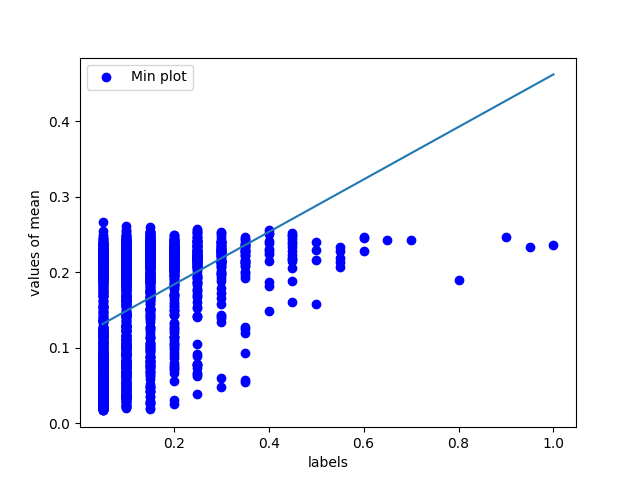

COPERNICUS_S2_SR_HARMONIZED_std.png


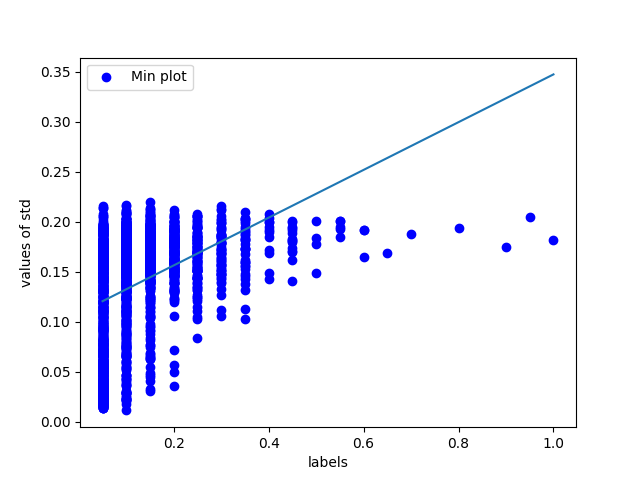

projects_HII_v1_driver_infrastructure_mean.png


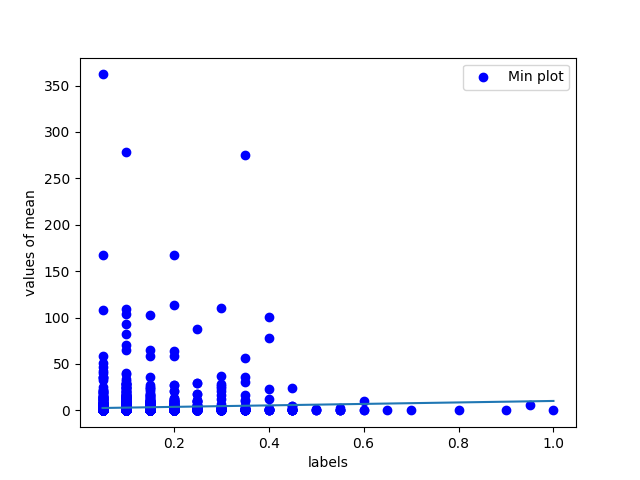

projects_HII_v1_driver_infrastructure_std.png


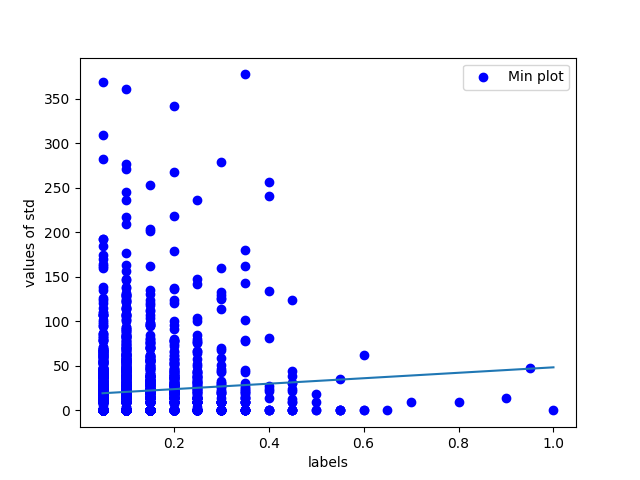

projects_HII_v1_driver_land_use_mean.png


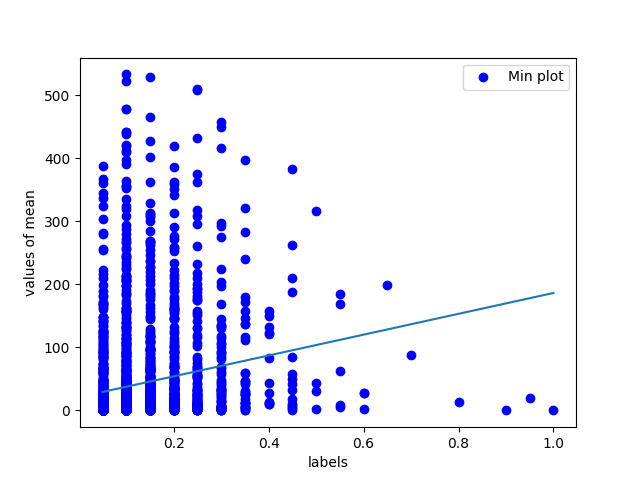

projects_HII_v1_driver_land_use_std.png


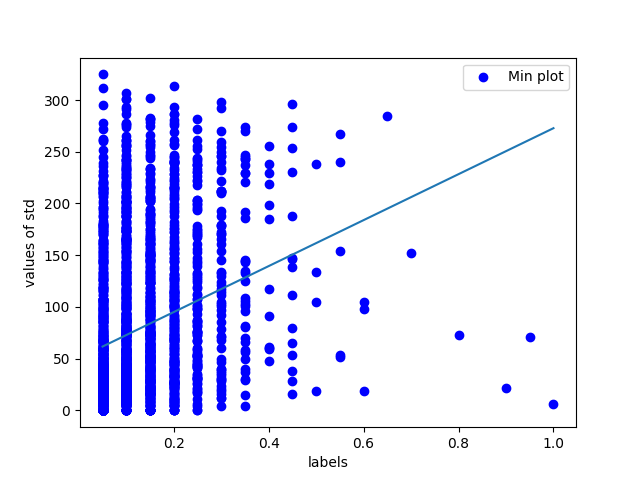

projects_HII_v1_driver_population_density_mean.png


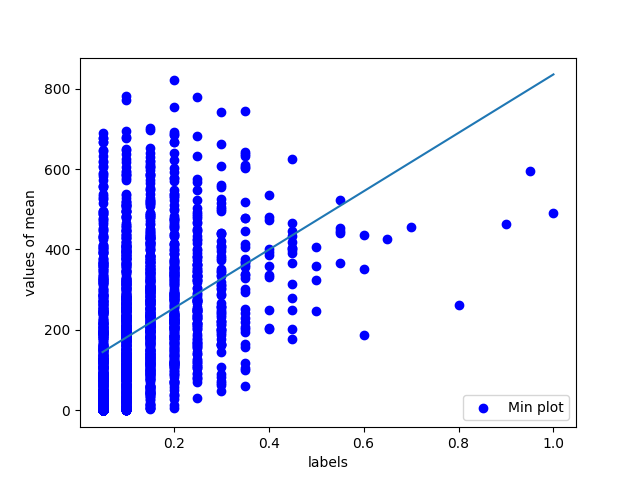

projects_HII_v1_driver_population_density_std.png


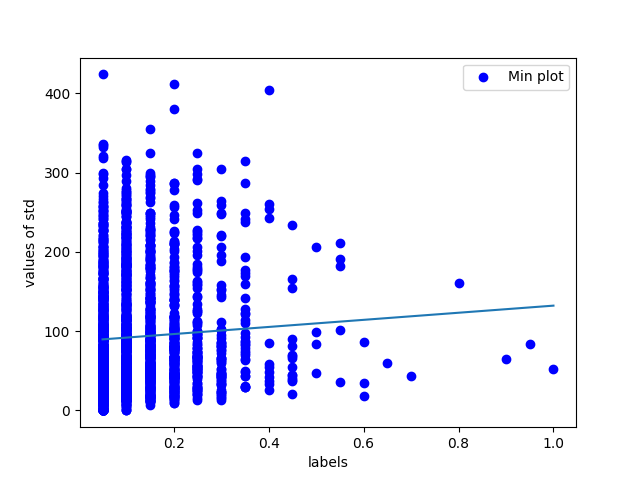

projects_HII_v1_driver_power_mean.png


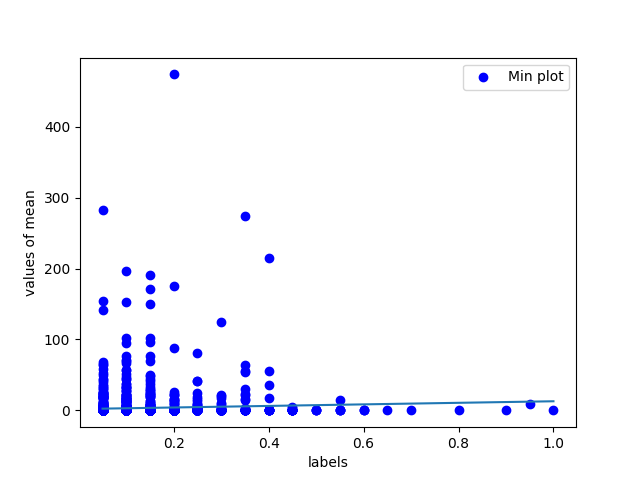

projects_HII_v1_driver_power_std.png


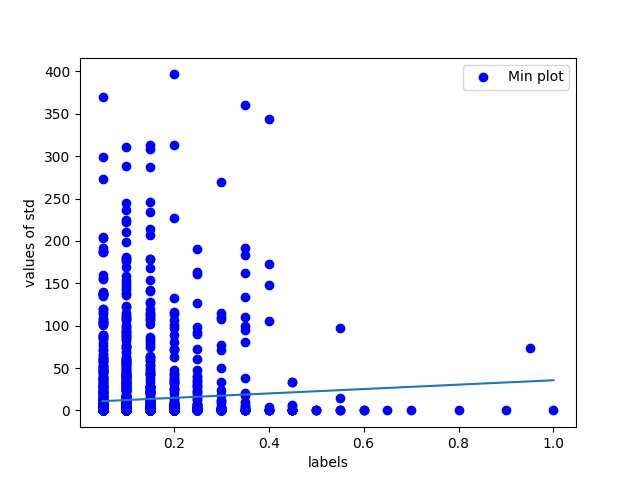

projects_HII_v1_driver_railways_mean.png


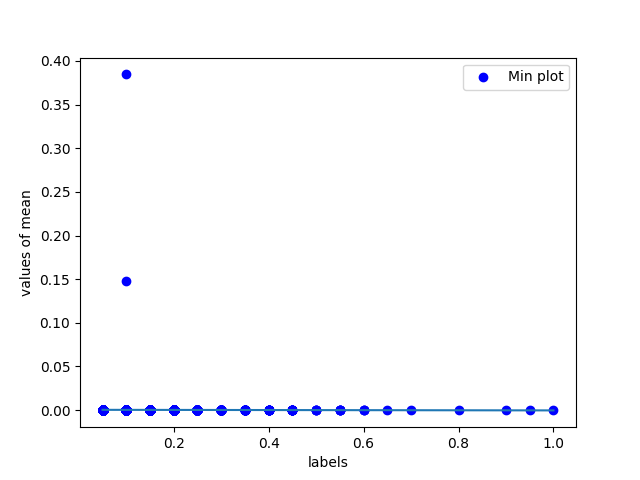

projects_HII_v1_driver_railways_std.png


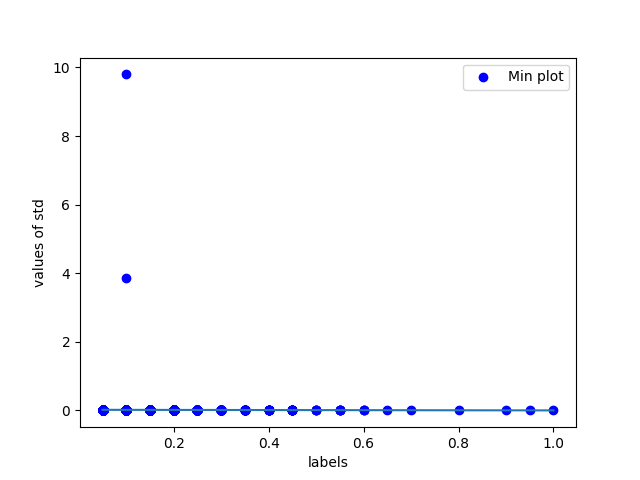

projects_HII_v1_driver_roads_mean.png


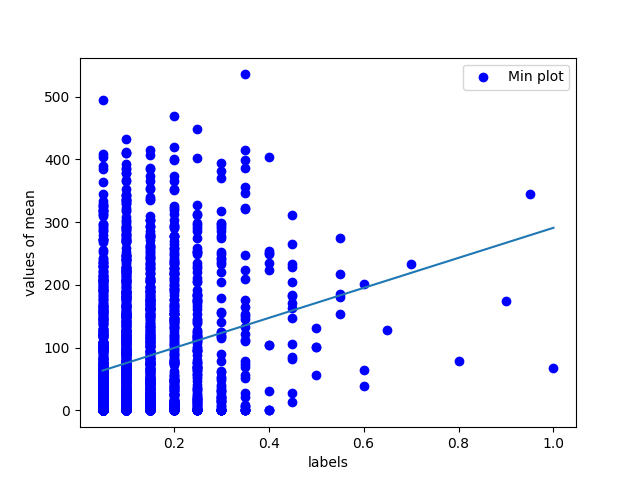

projects_HII_v1_driver_roads_std.png


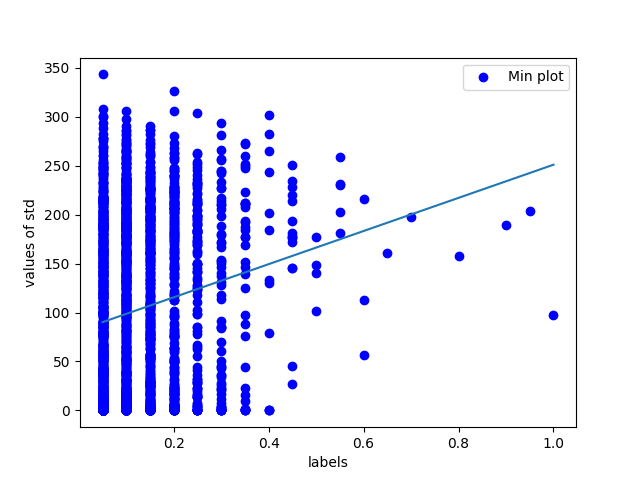

projects_HII_v1_driver_water_mean.png


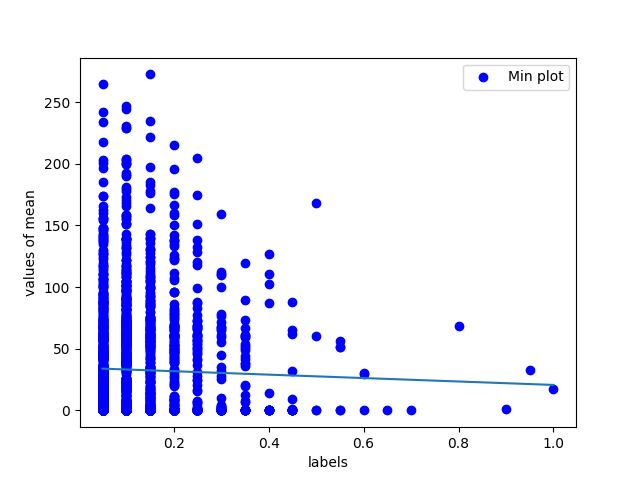

projects_HII_v1_driver_water_std.png


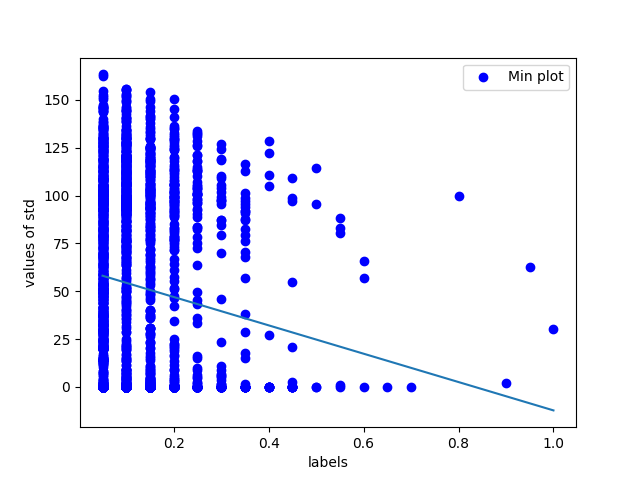

projects_sat-io_open-datasets_ASTER_GDEM_mean.png


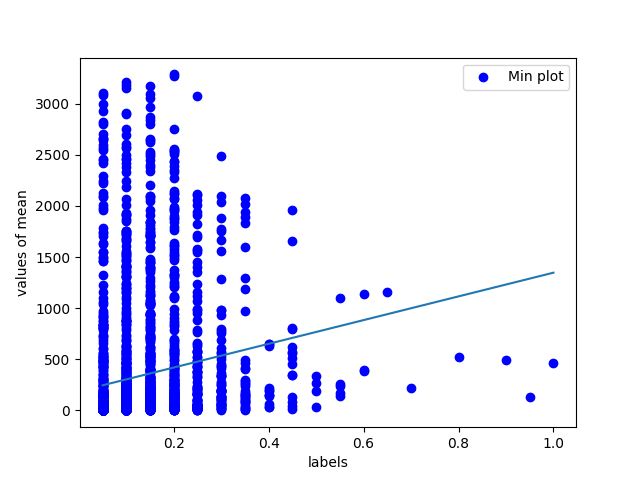

projects_sat-io_open-datasets_ASTER_GDEM_std.png


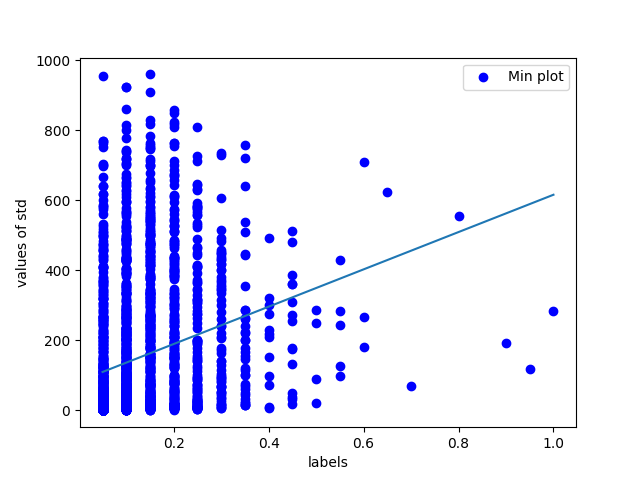

WORLDCLIM_V1_BIO_mean.png


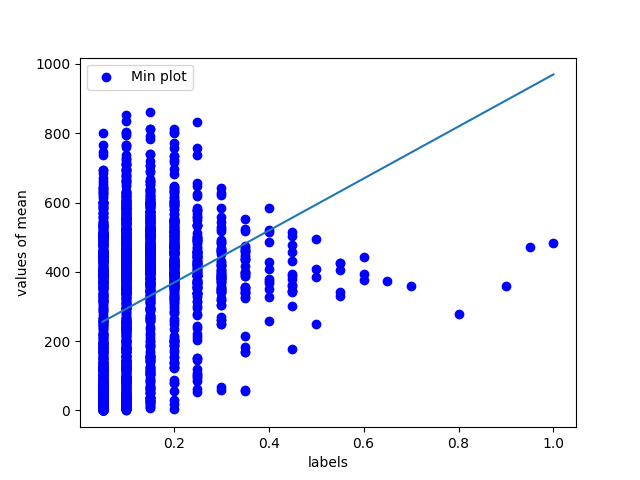

WORLDCLIM_V1_BIO_std.png


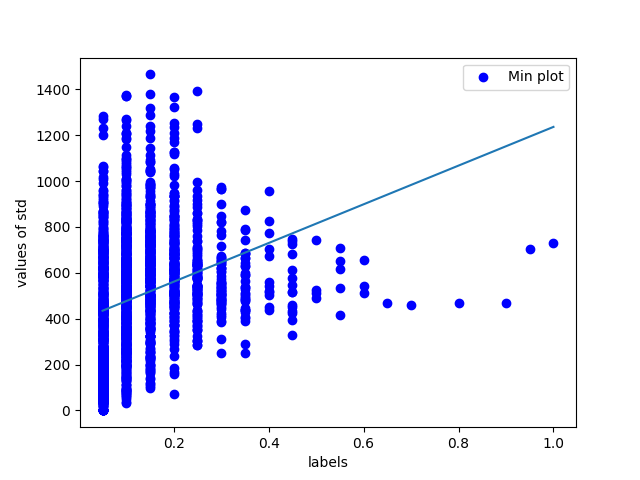

In [6]:
from IPython.display import Image
import os

images = os.listdir("plots")
for image in images:
    print(image)
    display(Image(f"plots/{image}"))


## Create a grid of squares

In [1]:
import geopandas as geopd
import pandas as pd
import numpy as np
from shapely import Polygon, affinity


In [2]:
#create grid
import numpy as np
from shapely import Polygon

#south america
grid_size = 25000
xmin = -9060000
ymin = -5400000
xmax = -3700000
ymax = 1500000
#papa new gu
# xmin = 14000000
# ymin = -1270000
# xmax = 18000000
# ymax = -000000
grid_df_name = f'south_america_grid_{grid_size}.gpgk'
grid_df_name = f'filled_south_america_grid_{grid_size}.gpgk'
#grid_df_name = f'world_grid_{grid_size}.gpgk'

def create_grid(xmin, xmax, ymin, ymax, grid_size):
    polygons = []
    for x0 in np.arange(xmin, xmax, grid_size):
        for y0 in np.arange(ymin, ymax, grid_size):
            x1 = x0 + grid_size
            y1 = y0 + grid_size
            polygon = Polygon([(x0,y0),(x1,y0),(x1,y1),(x0,y1)])
            polygons.append(polygon)


    new_grid_gdf = geopd.GeoDataFrame({'geometry': polygons})
    new_grid_gdf.crs = "ESRI:54034"
    new_grid_gdf.to_file(grid_df_name, driver="GPKG")
    return new_grid_gdf

grid_df = create_grid(xmin, xmax, ymin, ymax, grid_size)

In [4]:
#load the languages
language_df = geopd.read_file("../geopackage/world_language.gpkg")

In [5]:
#calculate the number of language overlaps in grids
#also create a bigger grid cell for each grid cell 
def get_overlaps(grid_df, language_df):
    for i, rect in enumerate(grid_df['geometry']):
        overlapped = rect.intersects(language_df['geometry'])
        centroid = rect.centroid
        scaled_polygon = affinity.scale(rect, xfact=3.0, yfact=3.0)
        scaled_overlapped = scaled_polygon.intersects(language_df['geometry'])
        if True in overlapped.value_counts():
            number_of_overlap = overlapped.value_counts()[True]
            number_of_scaled_overlap = scaled_overlapped.value_counts()[True]
            grid_df.loc[i, 'number_of_overlaps'] = number_of_overlap
            grid_df.loc[i, 'number_of_scaled_overlaps'] = number_of_scaled_overlap
            grid_df.loc[i, 'ID'] = f"{centroid.y:.6f}_{centroid.x:.6f}"
            
        else:  
            grid_df.loc[i, 'number_of_overlaps'] = 0
            grid_df.loc[i, 'number_of_scaled_overlaps'] = 0
            grid_df.loc[i, 'ID'] = f"{centroid.y:.6f}_{centroid.x:.6f}"

    return grid_df

grid_df = get_overlaps(grid_df, language_df)

In [ ]:
polygon = grid_df.iloc[0]['geometry']

scaled_polygon = affinity.scale(polygon, xfact=3.0, yfact=3.0)
print(grid_df.iloc[0]['geometry'])
print(scaled_polygon.wkt)

new_grid_gdf = geopd.GeoDataFrame({'geometry': [scaled_polygon]})
new_grid_gdf.crs = "ESRI:54034"
new_grid_gdf.to_file("south_america_scaled_polygon.gpkg", driver="GPKG")

In [6]:
#Remove all cells that has no language in it
def remove_no_data(grid_gdf):
    all_overlapped = []
    all_quadratic_overlapped = []
    ids = []
    for index, row in grid_gdf.iterrows():
        if row['number_of_overlaps'] == 0:
                grid_gdf.drop(index, inplace=True)
        else:
            centroid = row['geometry'].centroid
            all_overlapped.append(row['number_of_overlaps'])
            all_quadratic_overlapped.append(row['number_of_scaled_overlaps'])
            ids.append(f"{centroid.y:.6f}_{centroid.x:.6f}")
    
    all_overlapped_df = geopd.GeoDataFrame({"ID": ids, "overlapped": all_overlapped, "quadratic_overlapped": all_quadratic_overlapped})
    all_overlapped_df.to_csv("overlapped.csv", index=False)
    print("Överlapp sparade i 'overlapped.csv'.")


remove_no_data(grid_df)    

Överlapp sparade i 'overlapped.csv'.


In [ ]:
def find_neighbors(row, gdf):
    neighbors = gdf[gdf.geometry.touches(row.geometry)]
    return neighbors

def calculate_neighbour_avg(row, gdf):
    neighbors = find_neighbors(row, gdf)
    if not neighbors.empty:
        avg = neighbors['number_of_overlaps'].mean()
    else:
        avg = None
    return avg

grid_df['neighbours_avg'] = grid_df.apply(calculate_neighbour_avg, gdf=grid_df, axis=1)
grid_df.to_file(grid_df_name, driver="GPKG")

## Download data from google earth engine

In [ ]:
#Authenticate to google earth engine
import ee
import geemap
from urllib.request import urlretrieve

def GEE_initialize(service_account,json_path):
    credentials = ee.ServiceAccountCredentials(service_account, json_path)
    ee.Initialize(credentials)

#use your service account
service_account = 'accountname@ee-account.iam.gserviceaccount.com'
#point to your json key
json_path = 'key/ee-account-qweqweqwe.json'
GEE_initialize(service_account,json_path)

In [ ]:
from pyproj import Transformer
import os
import errno
from concurrent.futures import ThreadPoolExecutor,as_completed

#ee.Authenticate()
# Initialisera Google Earth Engine

def ensure_dir(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

def create_square(area):
            coords = area.getInfo()['coordinates'][0]
            minX = coords[0][0]
            maxX = coords[1][0]
            diff = maxX - minX
            minY = coords[0][1]
            maxY = minY + diff
            recalculated = ee.Geometry.Polygon([[minX, minY],[maxX, minY],[maxX, maxY],[minX, maxY]])
            return recalculated

def round_coordinate(coord, m_per_pixel):
    # Rounds the coordinate to the closest multiple of the pixel size
    remainder = coord % m_per_pixel
    if remainder < (m_per_pixel/2):
        coord = int(coord / m_per_pixel) * m_per_pixel
    else:
        coord = int((coord + m_per_pixel) / m_per_pixel) * m_per_pixel
    return coord

def get_image_collection_sample(collection, destination, scale, area, filter, **args):
    images = ee.ImageCollection(collection)
    if filter:
        images = filter(images, args)
    print(type(images))
    if type(images) == ee.image.Image:
        image = images
    else:
        print(type(images))
        print("get first!")
        image = images.first()
    print(image)
    print("download!")
    image = ee.Image(image)

    geemap.ee_export_image(image, filename=destination, scale=scale, region=area.getInfo(), crs='EPSG:4326', file_per_band=False)

def get_images_collection(grid_df, collection='CSP/HM/GlobalHumanModification', name='',  scale=1000, filter=None, **args):
    """
    Retrieves images from Google Earth Engine.

    Args:
        grid_df (geopandas.GeoDataFrame): A geographical dataset used for filtering images.
        collection (str): The name of the data collection available through the Google Earth Engine API.
            Default value is an example 'CSP/HM/GlobalHumanModification'.
        name (str, optional): An additional prefix that can be added to the downloaded images.
        scale (int, optional): Geographical size per pixel. Default value is 1000.
        filter (function, optional): A method used to filter images based on specific criteria.
        **args: Arguments used in the filter method.

    Returns:
        None
    """
    with ThreadPoolExecutor() as executor:
        transformer = Transformer.from_crs("ESRI:54034", "EPSG:4326", always_xy=True)
        dataset_name = collection.replace('/','_')
        if name=='':
            folder_name =  os.path.join(f"google_earth_download_{scale}",dataset_name) 
            name = dataset_name
        else:
            folder_name =  os.path.join(f"google_earth_download_{scale}",name) 
        ensure_dir(folder_name)

        for index, extent in grid_df.iterrows():
            destination = os.path.join(folder_name,f"[{extent['ID']}]{name}.tif")

            if os.path.isfile(destination):
                continue
            polygon_coords = []
            for x, y in extent['geometry'].exterior.coords:
                rounded_x = round_coordinate(x, scale)
                rounded_y = round_coordinate(y, scale)
                polygon_coords.append((int(rounded_y),int(rounded_x)))
    
            polygon_coords = polygon_coords[:4]
            new_polygon = [polygon_coords[0],polygon_coords[3],polygon_coords[2],polygon_coords[1]]
            wgs84_coords = [transformer.transform(y, x) for x, y in new_polygon]
            area = ee.Geometry.Polygon([wgs84_coords], proj='EPSG:4326')
            area = create_square(area)
            executor.submit(get_image_collection_sample, collection, destination, scale, area, filter, **args)


def get_image_sample(image_dataset, destination, scale, area):             
    image = ee.Image(image)
    geemap.ee_export_image(image, filename=destination, scale=scale, region=area.getInfo(), file_per_band=False)

def get_images_image(grid_df, image_dataset='CSP/ERGo/1_0/Global/SRTM_topoDiversity', name='', scale=1000):
    """
    Retrieves images from Google Earth Engine.

    Args:
        grid_df (geopandas.GeoDataFrame): A geographical dataset used for filtering images.
        collection (str): The name of the data collection available through the Google Earth Engine API.
            Default value is an example 'CSP/HM/GlobalHumanModification'.
        name (str, optional): An additional prefix that can be added to the downloaded images.
        scale (int, optional): Geographical size per pixel. Default value is 1000.
        filter (function, optional): A method used to filter images based on specific criteria.
        **args: Arguments used in the filter method.

    Returns:
        None
    """
    with ThreadPoolExecutor() as executor:
        transformer = Transformer.from_crs("ESRI:54034", "EPSG:4326", always_xy=True)
        dataset_name = image_dataset.replace('/','_')
        if name=='':
            folder_name =  os.path.join(f"google_earth_download_{scale}",dataset_name) 
            name = dataset_name
        else:
            folder_name =  os.path.join(f"google_earth_download_{scale}",name) 
        ensure_dir(folder_name)

        for index, extent in grid_df.iterrows():
            destination = os.path.join(folder_name,f"[{extent['ID']}]{name}.tif")
            if os.path.isfile(destination):
                continue
            polygon_coords = []
            for x, y in extent['geometry'].exterior.coords:
                rounded_x = round_coordinate(x, scale)
                rounded_y = round_coordinate(y, scale)
                polygon_coords.append((int(rounded_y),int(rounded_x)))    
            polygon_coords = polygon_coords[:4]
        
            
            new_polygon = [polygon_coords[0],polygon_coords[3],polygon_coords[2],polygon_coords[1]]

            wgs84_coords = [transformer.transform(y, x) for x, y in new_polygon]

            area = ee.Geometry.Polygon([wgs84_coords], proj='EPSG:4326')
            area = create_square(area)
            executor.submit(get_image_sample, image_dataset, destination, scale, area)

In [ ]:
#get_images_collection and get_images_image are able to take any filter mechanism. If a dataset requires a custom filter method, you simply set it as an argument. 
#Here we make sure to filter on date

def filter_date(image, *args):
    
    year1 = args[0]['year1']
    year2  = args[0]['year2']
    return image.filter(ee.Filter.calendarRange(year1, year2, 'year'))
get_images_collection(grid_df, "projects/HII/v1/driver/infrastructure", scale=100, filter=filter_date, year1=2023, year2=2023)



In [ ]:
#Following are all data that has been downloaded

def filter_date(image, *args):
    
    year1 = args[0]['year1']
    year2  = args[0]['year2']
    return image.filter(ee.Filter.calendarRange(year1, year2, 'year'))

get_images_collection(grid_df, "projects/HII/v1/driver/infrastructure", filter=filter_date, year1=2023, year2=2023, scale=100)
get_images_collection(grid_df, "projects/HII/v1/driver/land_use", filter=filter_date, year1=2023, year2=2023, scale=100)
get_images_collection(grid_df, "projects/HII/v1/driver/population_density", filter=filter_date, year1=2023, year2=2023, scale=100)
get_images_collection(grid_df, "projects/HII/v1/driver/power", filter=filter_date, year1=2023, year2=2023, scale=100)
get_images_collection(grid_df, "projects/HII/v1/driver/railways", filter=filter_date, year1=2023, year2=2023, scale=100)
get_images_collection(grid_df, "projects/HII/v1/driver/roads", filter=filter_date, year1=2023, year2=2023, scale=100)
get_images_collection(grid_df, "projects/HII/v1/driver/water", filter=filter_date, year1=2023, year2=2023, scale=100)
get_images_collection(grid_df, "projects/HII/v1/hii", filter=filter_date, year1=2023, year2=2023, scale=100)


get_images_image(grid_df, "projects/sat-io/open-datasets/ASTER/GDEM", scale=100)
get_images_image(grid_df, "WORLDCLIM/V1/BIO", scale=100)


def ndvi_filter(image, *args):
    def maskS2clouds(image):
        # This function is copied from GEE examples library and convert from JavaScript to Python
        # Function to mask clouds using the Sentinel-2 QA band.
        qa = image.select('QA60')
        # Bits 10 and 11 are clouds and cirrus, respectively.
        cloudBitMask = 1 << 10
        cirrusBitMask = 1 << 11
        # Both flags should be set to zero, indicating clear conditions.
        mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
        # Return the masked and scaled data, without the QA bands.
        return image.updateMask(mask).divide(10000).select("B.*").copyProperties(image, ["system:time_start"])
    def add_ndvi(image):
        # Normalized difference vegetation index (NDVI)
        ndvi = image.normalizedDifference(['B8', 'B4']).rename("NDVI")
        image = image.addBands(ndvi)
        return image
    year1 = args[0]['year1']
    year2  = args[0]['year2']
    s2_collection = image.filter(ee.Filter.calendarRange(year1, year2, 'year')) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 80)) \
    .map(maskS2clouds)
    # .filter(ee.Filter.calendarRange(6, 8, 'month')) \
    
    #s2_collection = image.filterDate('2023-06-01', '2023-07-30') \
    
    
   # s2_collection = s2_collection.median()
    s2_collection = s2_collection.median()
    s2_collection = add_ndvi(s2_collection)

    return s2_collection

get_images_collection(grid_df,"COPERNICUS/S2_SR_HARMONIZED", scale=100, filter=ndvi_filter, year1=2023, year2=2023)

## Train

This is example commands to start a training
### python train.py --architecture cnn --model detail_estimator_cnn_model --configuration LangCnn --dataset_module detail_estimator_dataset_cnn --epochs 20 --batch_size 8 --learning_rate 1e-3 --mlflow cnn_all --feature_data_dir features_100


## Train
this is example commands to start a training
python train.py --architecture cnn --model detail_estimator_cnn_model --configuration LangCnn --dataset_module detail_estimator_dataset_cnn --epochs 20 --batch_size 8 --learning_rate 1e-3 --mlflow cnn_all --feature_data_dir features_100


We have developed a system that is flexible to test out different architectures and approaches. We've been focus on the directory structure to have architectures and approaches organized.  With that comes a little steep learning curve for the user to understand how to use the system for experimentation

--architecture
The first layer is to chose an architecture. It's an easy and convenient way to separate different machine learning approaches such as Convolutional Neural Network, Fully Connected Neural Network, Regression Models and so on.

--model
In each architecture there must be a algorithm definition in a python file. This file must have the method "load_model". This is how the model are being loaded in the training. Look into source/architectures/cnn/detail_estimatior_cnn_model.py to see a simple example

--configuration
You need to set the configuration for the model. In each architecture there must be a configuration.json file. The main purpose of configuration is to decide what features should be used. But a powerful functionality is that you can define model specific configurations in here. For example if you want a specific number of hidden layers in your model, you can define it in the configuration.json. But then you of course need to implement the functionality in your model file.

--dataset_module
In each architecture there must be a dataset module. This file must have the method "prepare_dataset". This is how the dataset is prepared and fit for the model. If there is custom configuration functionality you want in here aswell, it's prepared. 

--mlflow
Set a name for the experiment. Use mlflow to get an organized way to record your training. Our method make sure to store all architecture files to make sure that all important settings will be stored and not get lost when you changes the code for a new experiment. (To run mlflow run following command "mlflow ui". Open your favorite broswer and head over to : http://127.0.0.1:5000/)


--feature_data_dir
Point to a sub directory where the feature data is stored, for example --feature_data_dir features_100


python trainregressor.py --architecture random_forest_regressor --model linear_regressor --configuration Lang --dataset_module random_forest_regressor_dataset --mlflow linear_regressor --feature_data_dir features_100

python trainregressor.py --architecture random_forest_regressor --model random_forest_regressor_model --configuration Lang --dataset_module random_forest_regressor_dataset --mlflow random_forest --feature_data_dir features_100


python train.py --architecture cnn --model detail_estimator_cnn_model --configuration LangCnn --dataset_module detail_estimator_dataset_cnn --epochs 20 --batch_size 8 --learning_rate 1e-3 --mlflow cnn_all --feature_data_dir features_100

python train.py --architecture cnn --model detail_estimator_cnn_model --configuration LangCnnMultiLabel --dataset_module detail_estimator_dataset_cnn --epochs 20 --batch_size 8 --learning_rate 1e-3 --mlflow cnn_all --feature_data_dir features_100 --multi_label
